In [167]:
import pandas as pd, csv, json, numpy as np, requests, matplotlib.pyplot as plt, networkx as nx
from lxml import etree
import xml.etree.ElementTree as ET
from multiprocessing import Pool, cpu_count
from multiprocessing import Process
from hw2_utils import *

### PPI

In [2]:
# Human proteins
url = 'https://rest.uniprot.org/uniprotkb/stream?fields=accession%2Creviewed%2Cid%2Cprotein_name%2Cgene_names&format=json&query=%28reviewed%3Atrue%20AND%20proteome%3Aup000005640%29'
res = requests.get(url)
r = res.json()
human_protein_ids = set([entry['primaryAccession'] for entry in r['results']])
human_protein_ids = list(human_protein_ids)
json.dump(human_protein_ids, open('data/human_protein_ids.json','w'))

'''STRING-UniProt Mapping'''
### API
job_id = submit_id_mapping_UniProtAPI(
                  from_db = 'UniProtKB_AC-ID',
                  to_db = 'STRING',
                  ids = human_protein_ids)
if check_id_mapping_results_ready_UniProtAPI(job_id):
    link = get_id_mapping_results_link_UniProtAPI(job_id)
    results = get_id_mapping_results_search_UniProtAPI(link)

### Extract and map
stringISuniprot, uniprotISstring = dict(), dict()
for u2s in results['results']:
    uniprot = u2s['from']
    string  = u2s['to']
    if '9606' in string:
        uniprotISstring[uniprot] = string
        stringISuniprot[string] = uniprot
print(len(stringISuniprot),'/',len(human_protein_ids), 'UniProt proteins aligned with STRING')


'''STRING PPI'''
string_ids = list(stringISuniprot.keys())
SCORE_THRESH = 0.70
string_ppi_df, counts1 = k_hop_interactors_STRINGAPI(string_ids, \
                                          k=5, \
                                          score_thresh = SCORE_THRESH,\
                                          debug = True, \
                                          return_counts = True)
string_ppi_df.tail()


### Export edges
with open('data/edges_protein2protein_string.csv','w') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Protein (UniProt)','Protein (UniProt)','Relationship','Weight'])
    string2string_ppi = dict()
    
    for i in range(0,len(string_ppi_df)):
        try:
            protein1 = stringISuniprot[string_ppi_df['query_ensp'].iloc[i]]
            protein2 = stringISuniprot[string_ppi_df['partner_ensp'].iloc[i]]
            score = str((1-string_ppi_df['combined_score'].iloc[i])/(1-SCORE_THRESH))
            writer.writerow(['UniProt:'+protein1, 'UniProt:'+protein2, '-ppi-',score])
            string2string_ppi.setdefault(protein1,[]).append(protein2)
        except:
            continue
            
    string_ppi_df = pd.read_csv('data/edges_protein2protein_string.csv').drop_duplicates()
string_ppi_df.to_csv('data/edges_protein2protein_string.csv', index=False)
string_ppi_df = string_ppi_df.apply(lambda S:S.astype(str).str.strip('UniProt:'))
string_ppi_df.tail()

KeyboardInterrupt: 

### Gene to Protein Mapping

In [150]:
'''API'''
human_protein_ids = json.load(open('data/human_protein_ids.json'))
job_id = submit_id_mapping_UniProtAPI(
                  from_db = 'UniProtKB_AC-ID',
                  to_db = 'GeneID', 
                  ids = human_protein_ids)
if check_id_mapping_results_ready_UniProtAPI(job_id):
    link = get_id_mapping_results_link_UniProtAPI(job_id)
    results = get_id_mapping_results_search_UniProtAPI(link)
    
    
'''Extract and Map'''
gene_id_2_protein_id = dict()
protein_id_2_gene_id = dict()
for protein_to_gene in results['results']:
    protein_id = protein_to_gene['from'].strip()
    gene_id = protein_to_gene['to'].strip()
    if gene_id != '' and protein_id != '':
        gene_id_2_protein_id.setdefault(gene_id, set()).add(protein_id)
        protein_id_2_gene_id.setdefault(protein_id, set()).add(gene_id)
    
print('Entrez-is-UniProt', len(gene_id_2_protein_id),'\n'+\
      'UniProt-is-Entrez', len(protein_id_2_gene_id))
gene_id_2_protein_id = switch_dictset_to_dictlist(gene_id_2_protein_id)
protein_id_2_gene_id = switch_dictset_to_dictlist(protein_id_2_gene_id)

Entrez-is-UniProt 19016 
UniProt-is-Entrez 18870


### Disease-Gene List (Filtered by High Quality)

In [151]:
#! wget -P data/ https://www.disgenet.org/static/disgenet_ap1/files/downloads/all_gene_disease_associations.tsv.gz
#! gunzip data/all_gene_disease_associations.tsv.gz
disgen_df = pd.read_table('data/all_gene_disease_associations.tsv')
disgen_df['diseaseName'] = disgen_df['diseaseName'].str.lower()
narcolepsy_df = disgen_df[disgen_df['diseaseName'].str.contains('narcolepsy')]
narcolepsy_df.reset_index()
narcolepsy_df.to_csv('data/narcolepsy_df.csv', index=False)
narcolepsy_df.tail()

,geneId,geneSymbol,DSI,DPI,diseaseId,diseaseName,diseaseType,diseaseClass,diseaseSemanticType,score,EI,YearInitial,YearFinal,NofPmids,NofSnps,source
1127406,102723742,LINC01500,0.760,0.192,C0027404,narcolepsy,disease,C10;F03,Disease or Syndrome,0.1,1.0,2009.0,2009.0,1,2,GWASDB
1128990,105370309,LINC02336,0.861,0.192,C0027404,narcolepsy,disease,C10;F03,Disease or Syndrome,0.1,1.0,2009.0,2009.0,1,1,GWASDB
1129352,105374251,LINC01839,0.890,0.115,C0027404,narcolepsy,disease,C10;F03,Disease or Syndrome,0.1,1.0,2009.0,2009.0,1,1,GWASDB
1129769,105377441,LINC02511,0.931,0.077,C0027404,narcolepsy,disease,C10;F03,Disease or Syndrome,0.1,1.0,2009.0,2009.0,1,1,GWASDB
1131349,107984780,LINC02248,1.000,0.077,C0027404,narcolepsy,disease,C10;F03,Disease or Syndrome,0.1,1.0,2009.0,2009.0,1,1,GWASDB


In [153]:
'''Filter genes by high quality sources'''
high_quality_sources = ['GWASDB','GWASCAT','CTD_human','ORPHANET','CLINVAR','HPO','CLINGEN','GENOMICS ENGLAND','PSYGENET','UNIPROT']
high_quality_rows = list()
for row_num, source_entry in enumerate(narcolepsy_df['source']):
    if source_entry in high_quality_sources:
        high_quality_rows.append(True)
    else:
        high_quality_rows.append(False)
narcolepsy_df = narcolepsy_df[high_quality_rows]

''' Map Gene-Protein '''
narcolepsy_proteins = set()
for i in range(0, len(narcolepsy_df)):
    gene_id = str(narcolepsy_df['geneId'].iloc[i])
    try: 
        proteins = gene_id_2_protein_id[gene_id]
        for protein in proteins:
            narcolepsy_proteins.add(protein)
    except: 
        continue
print(len(narcolepsy_proteins), 'narcolepsy-associated proteins')
json.dump(list(narcolepsy_proteins), open('data/narcolepsy_proteins.json','w'))

178 narcolepsy-associated proteins


### Load in files produced above

In [155]:
#narcolepsy_proteins = ['UniProt:'+protein for protein in json.load(open('data/narcolepsy_proteins.json'))]
narcolepsy_proteins = json.load(open('data/narcolepsy_proteins.json'))
narcolepsy_df = pd.read_csv(open('data/narcolepsy_df.csv'))

human_protein_ids = json.load(open('data/human_protein_ids.json'))
string_ppi_df = pd.read_csv('data/edges_protein2protein_string.csv').drop_duplicates()
interactome_proteins = list(set(string_ppi_df['Protein (UniProt)']).union(set(string_ppi_df['Protein (UniProt).1'])))

protein_id2names = json.load(open('../../Drug Repurposing Knowledge Graph/output/protein2protein/protein_id2names.json'))

### Network

#### Disease-PPI

In [156]:
'''Choose disease'''
disease_proteins = narcolepsy_proteins
disease_name = 'Narcolepsy'
print(len(interactome_proteins), 'interactome proteins')
print(len(disease_proteins), 'disease proteins')

16236 interactome proteins
178 disease proteins


In [157]:
'''Create main graph'''
G = make_ppi_disease_graph(proteins = disease_proteins, 
                           disease_name = disease_name, 
                           ppi_df = string_ppi_df)
print('PPI Graph')
connected_components_g = display_connected_components(G, histogram = False)

PPI Graph
83 connected components
{Size of CC : Number of CCs}
{16090: 1, 9: 1, 5: 2, 4: 6, 3: 6, 2: 67}


In [166]:
'''Create Disease Proteins Subgraph (100% of Disease Proteins)'''
print('Disease-Proteins Subgraph')
SG100 = G.subgraph(disease_proteins)

# Get the subgraph's connected components
cc_counts, connected_components_sg100 = get_connected_components(SG100)
print('{Size of CC : Number of CCs}\n'+str(cc_counts))

Disease-Proteins Subgraph
{Size of CC : Number of CCs}
{4: 1, 2: 11, 1: 152}


Size|Count


4    64
2    18
3    18
dtype: int64

4 is the largest connected component


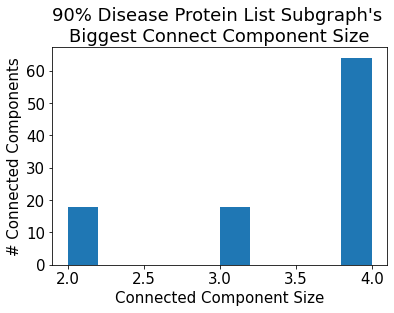

In [196]:
'''Create Disease Proteins Subgraph (90% of Narcolepsy-Associated Proteins)'''
disease_subgraphs_ccs_counts, disease_subgrahps_ccs = get_100_subgraphs(disease_proteins, ninety_percent_of_this_list = disease_proteins)
largest_cc_sizes = plot_largest_connected_component_histogram(title='90% Disease Protein List Subgraph\'s \nBiggest Connect Component Size',
                                                              subgraphs_ccs_counts = disease_subgraphs_ccs_counts)
print('Largest Size|Count')
display(pd.Series(sorted(largest_cc_sizes)).value_counts())
print(max(largest_cc_sizes), 'is the largest connected component')

Note: Subset size is the same number of random proteins as 90% of disease proteins
Size|Count


5     14
6     12
4     12
8     11
7     10
9      9
11     8
10     5
3      4
16     3
12     3
14     2
13     2
15     1
17     1
19     1
20     1
22     1
dtype: int64

22 is the largest connected component


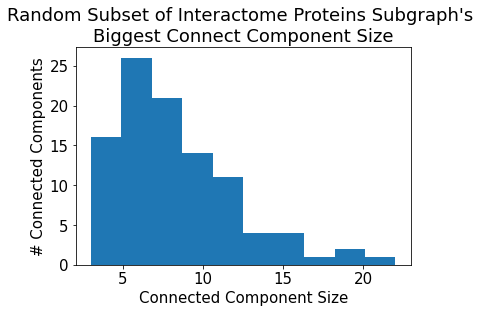

In [197]:
interactome_subgraphs_ccs_counts, interactome_subgrahps_ccs = get_100_subgraphs(interactome_proteins, ninety_percent_of_this_list = disease_proteins)
largest_cc_sizes = plot_largest_connected_component_histogram(title='Random Subset of Interactome Proteins Subgraph\'s \nBiggest Connect Component Size',
                                         subgraphs_ccs_counts = interactome_subgraphs_ccs_counts)
print('Note: Subset size is the same number of random proteins as 90% of disease proteins')
print('Largest Size|Count')
display(pd.Series(sorted(largest_cc_sizes)).value_counts())
print(max(largest_cc_sizes), 'is the largest connected component')
print('Average largest connected component', np.mean(largest_cc_sizes))

8.1

In [161]:
print('Proteins in the largest connected component of the disease protein subgraph:\n', 
      connected_components_sg100[0])

Proteins in the largest connected component of the disease protein subgraph:
 {'Q9BZK7', 'Q03188', 'Q9UKV0', 'Q93077'}


In [162]:
### API
job_id = submit_id_mapping_UniProtAPI(
                  from_db = 'UniProtKB_AC-ID',
                  to_db = 'UniProtKB',
                  ids = list(connected_components_sg100[0]))
if check_id_mapping_results_ready_UniProtAPI(job_id):
    link = get_id_mapping_results_link_UniProtAPI(job_id)
    results = get_id_mapping_results_search_UniProtAPI(link)

Job still running. Retrying in 3s


In [222]:
for entry in results['results']:
    display(entry['from'])
    display(entry['to']['proteinDescription'])
    display(entry['to']['genes'][0])
    display(entry['to']['comments'])
    print('\n\n')

'Q9BZK7'

{'recommendedName': {'fullName': {'value': 'F-box-like/WD repeat-containing protein TBL1XR1'}},
 'alternativeNames': [{'fullName': {'value': 'Nuclear receptor corepressor/HDAC3 complex subunit TBLR1'}},
  {'fullName': {'value': 'TBL1-related protein 1'}},
  {'fullName': {'value': 'Transducin beta-like 1X-related protein 1'}}]}

{'geneName': {'value': 'TBL1XR1'},
 'synonyms': [{'value': 'IRA1'}, {'value': 'TBLR1'}]}

[{'texts': [{'evidences': [{'evidenceCode': 'ECO:0000269',
      'source': 'PubMed',
      'id': '14980219'}],
    'value': 'F-box-like protein involved in the recruitment of the ubiquitin/19S proteasome complex to nuclear receptor-regulated transcription units. Plays an essential role in transcription activation mediated by nuclear receptors. Probably acts as integral component of the N-Cor corepressor complex that mediates the recruitment of the 19S proteasome complex, leading to the subsequent proteasomal degradation of N-Cor complex, thereby allowing cofactor exchange, and transcription activation'}],
  'commentType': 'FUNCTION'},
 {'texts': [{'evidences': [{'evidenceCode': 'ECO:0000250',
      'source': 'UniProtKB',
      'id': 'Q8BHJ5'},
     {'evidenceCode': 'ECO:0000269', 'source': 'PubMed', 'id': '11931768'},
     {'evidenceCode': 'ECO:0000269', 'source': 'PubMed', 'id': '12628926'}],
    'value': 'Component of the N-Cor repressor complex, at least composed of NCOR1, NCOR2, HD

'Q03188'

{'recommendedName': {'fullName': {'value': 'Centromere protein C'},
  'shortNames': [{'value': 'CENP-C'}]},
 'alternativeNames': [{'fullName': {'value': 'Centromere autoantigen C'}},
  {'fullName': {'value': 'Centromere protein C 1'},
   'shortNames': [{'value': 'CENP-C 1'}]},
  {'fullName': {'value': 'Interphase centromere complex protein 7'}}]}

{'geneName': {'value': 'CENPC'},
 'synonyms': [{'value': 'CENPC1'}, {'value': 'ICEN7'}]}

[{'texts': [{'evidences': [{'evidenceCode': 'ECO:0000269',
      'source': 'PubMed',
      'id': '19482874'},
     {'evidenceCode': 'ECO:0000269', 'source': 'PubMed', 'id': '21529714'}],
    'value': 'Component of the CENPA-NAC (nucleosome-associated) complex, a complex that plays a central role in assembly of kinetochore proteins, mitotic progression and chromosome segregation. The CENPA-NAC complex recruits the CENPA-CAD (nucleosome distal) complex and may be involved in incorporation of newly synthesized CENPA into centromeres. CENPC recruits DNA methylation and DNMT3B to both centromeric and pericentromeric satellite repeats and regulates the histone code in these regions'}],
  'commentType': 'FUNCTION'},
 {'texts': [{'evidences': [{'evidenceCode': 'ECO:0000250',
      'source': 'UniProtKB',
      'id': 'P49452'},
     {'evidenceCode': 'ECO:0000269', 'source': 'PubMed', 'id': '16622419'},
     {'evidenceCode': 'ECO:0000269', 'source': 'PubMed', 'id': '19482874'},
     {'evidenceCod

'Q9UKV0'

{'recommendedName': {'fullName': {'value': 'Histone deacetylase 9'},
  'shortNames': [{'value': 'HD9'}],
  'ecNumbers': [{'evidences': [{'evidenceCode': 'ECO:0000269',
      'source': 'PubMed',
      'id': '11535832'}],
    'value': '3.5.1.98'}]},
 'alternativeNames': [{'fullName': {'value': 'Histone deacetylase 7B'},
   'shortNames': [{'value': 'HD7'}, {'value': 'HD7b'}]},
  {'fullName': {'value': 'Histone deacetylase-related protein'}},
  {'fullName': {'value': 'MEF2-interacting transcription repressor MITR'}}]}

{'geneName': {'value': 'HDAC9'},
 'synonyms': [{'value': 'HDAC7'},
  {'value': 'HDAC7B'},
  {'value': 'HDRP'},
  {'value': 'KIAA0744'},
  {'value': 'MITR'}]}

[{'texts': [{'evidences': [{'evidenceCode': 'ECO:0000269',
      'source': 'PubMed',
      'id': '11535832'}],
    'value': 'Responsible for the deacetylation of lysine residues on the N-terminal part of the core histones (H2A, H2B, H3 and H4). Histone deacetylation gives a tag for epigenetic repression and plays an important role in transcriptional regulation, cell cycle progression and developmental events. Represses MEF2-dependent transcription'}],
  'commentType': 'FUNCTION'},
 {'texts': [{'value': 'Isoform 3 lacks active site residues and therefore is catalytically inactive. Represses MEF2-dependent transcription by recruiting HDAC1 and/or HDAC3. Seems to inhibit skeletal myogenesis and to be involved in heart development. Protects neurons from apoptosis, both by inhibiting JUN phosphorylation by MAPK10 and by repressing JUN transcription via HDAC1 recruitment to JUN promoter'}],
  'commentType': 'FUNCTION'},
 {'commentType': 'CATALYTIC ACTIVITY',
  'reaction': {'name': 'H2O + N(6

'Q93077'

{'recommendedName': {'fullName': {'value': 'Histone H2A type 1-C'}},
 'alternativeNames': [{'fullName': {'evidences': [{'evidenceCode': 'ECO:0000312',
      'source': 'HGNC',
      'id': 'HGNC:4733'}],
    'value': 'H2A-clustered histone 6'}},
  {'fullName': {'value': 'Histone H2A/l'}}]}

{'geneName': {'evidences': [{'evidenceCode': 'ECO:0000312',
    'source': 'HGNC',
    'id': 'HGNC:4733'}],
  'value': 'H2AC6'},
 'synonyms': [{'value': 'H2AFL'},
  {'evidences': [{'evidenceCode': 'ECO:0000312',
     'source': 'HGNC',
     'id': 'HGNC:4733'}],
   'value': 'HIST1H2AC'}]}

[{'texts': [{'value': 'Core component of nucleosome. Nucleosomes wrap and compact DNA into chromatin, limiting DNA accessibility to the cellular machineries which require DNA as a template. Histones thereby play a central role in transcription regulation, DNA repair, DNA replication and chromosomal stability. DNA accessibility is regulated via a complex set of post-translational modifications of histones, also called histone code, and nucleosome remodeling'}],
  'commentType': 'FUNCTION'},
 {'texts': [{'value': 'The nucleosome is a histone octamer containing two molecules each of H2A, H2B, H3 and H4 assembled in one H3-H4 heterotetramer and two H2A-H2B heterodimers. The octamer wraps approximately 147 bp of DNA'}],
  'commentType': 'SUBUNIT'},
 {'commentType': 'INTERACTION',
  'interactions': [{'interactantOne': {'uniProtKBAccession': 'Q93077',
     'intActId': 'EBI-725259'},
    'interactantTwo': {'uniProtKBAccession': 'P46379-2',
     'geneName': 'BAG6',
     'intActId': 'EBI-1098886

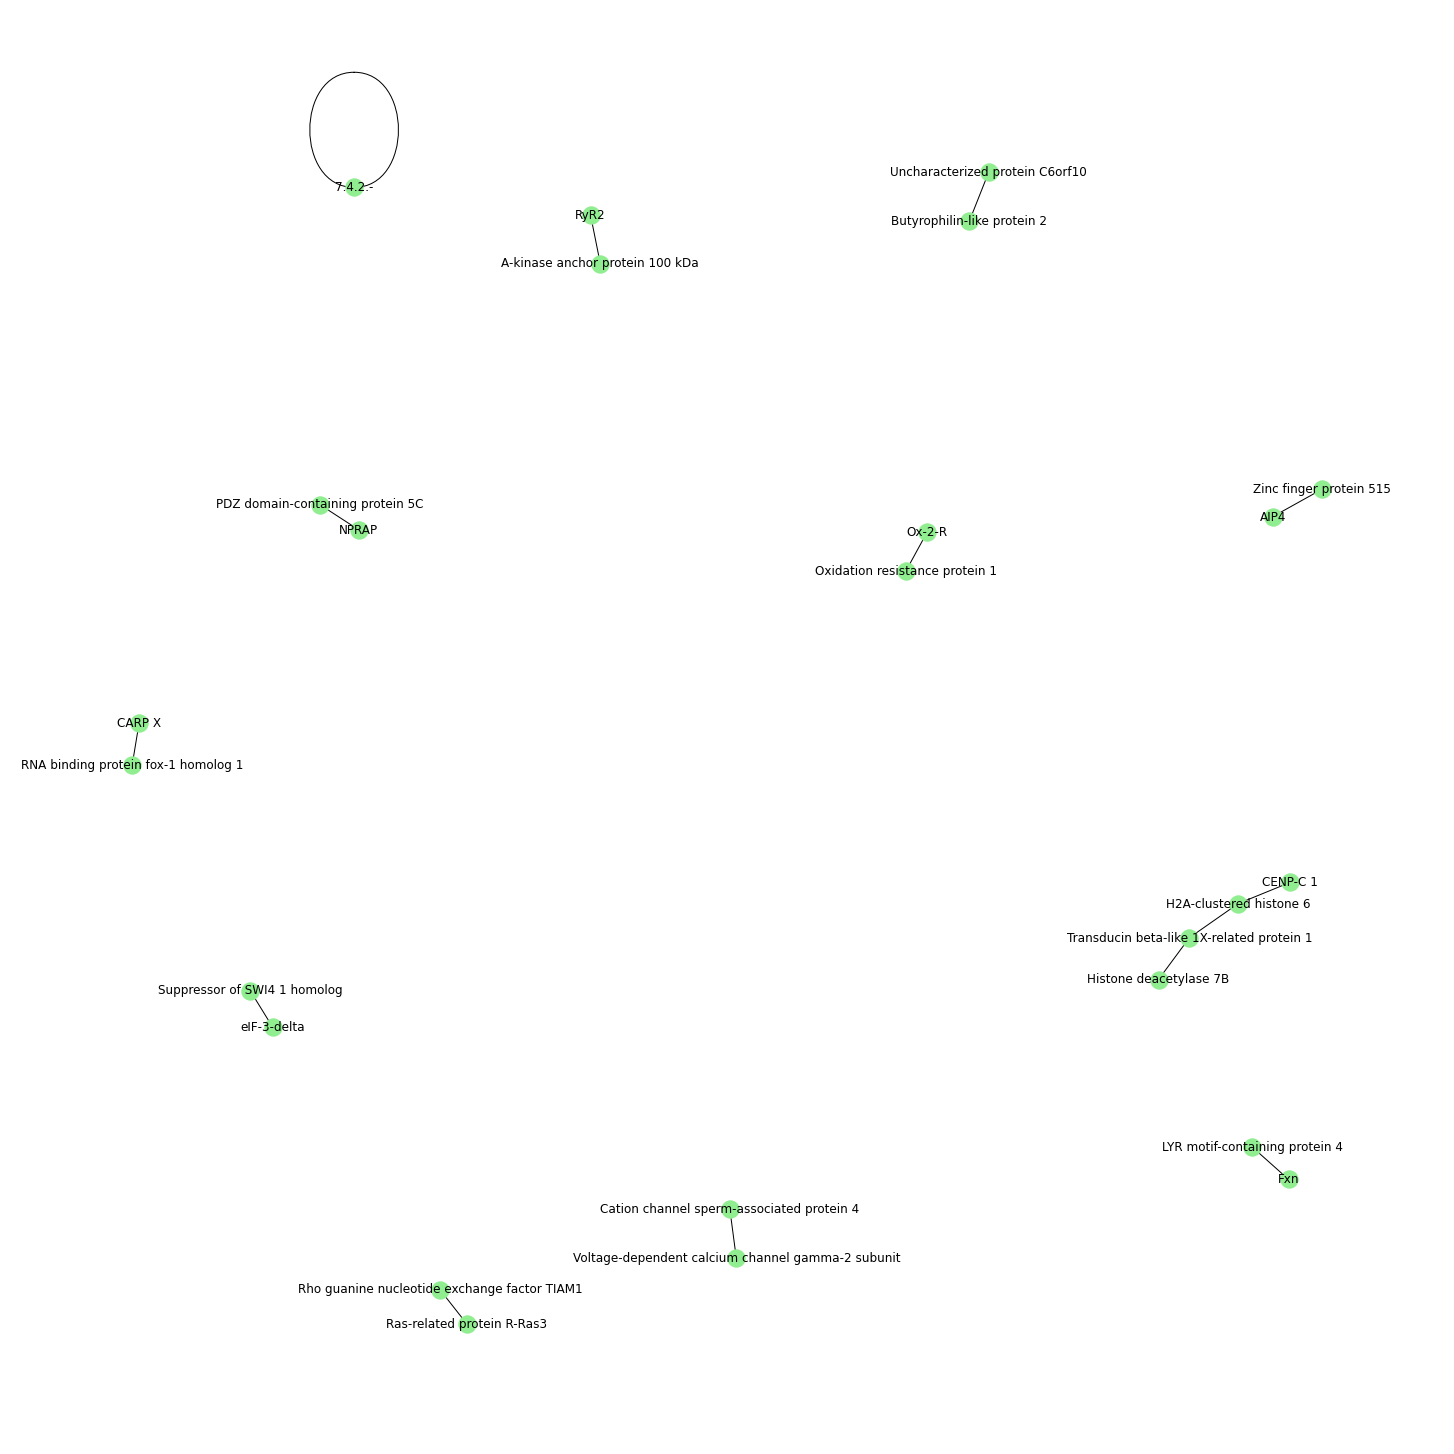

In [223]:
SG = G.subgraph(narcolepsy_proteins).to_undirected()
node2degree = {node:deg for (node, deg) in SG.degree()}
zero_deg_nodes = [node for node,degrees in node2degree.items() if degrees < 1]
SG_pruned = SG.copy()
SG_pruned.remove_nodes_from([node for node in SG_pruned if node in zero_deg_nodes])
SG_pruned = translate_proteinid2name_graph(SG_pruned, protein_id2names)

plt.figure(figsize=(20, 20))
nx.draw(SG_pruned, with_labels=True, node_color='lightgreen')

In [238]:
print('O43612' in narcolepsy_proteins,
      'O43613' in narcolepsy_proteins,
      'O43614' in narcolepsy_proteins)

True True True


### Disease-Gene List (Not Filtered by Quality)

In [239]:
#! wget -P data/ https://www.disgenet.org/static/disgenet_ap1/files/downloads/all_gene_disease_associations.tsv.gz
#! gunzip data/all_gene_disease_associations.tsv.gz
disgen_df = pd.read_table('data/all_gene_disease_associations.tsv')
disgen_df['diseaseName'] = disgen_df['diseaseName'].str.lower()
narcolepsy_df = disgen_df[disgen_df['diseaseName'].str.contains('narcolepsy')]
narcolepsy_df.reset_index()
narcolepsy_df.to_csv('data/narcolepsy_df.csv', index=False)
narcolepsy_df.tail()

,geneId,geneSymbol,DSI,DPI,diseaseId,diseaseName,diseaseType,diseaseClass,diseaseSemanticType,score,EI,YearInitial,YearFinal,NofPmids,NofSnps,source
1127406,102723742,LINC01500,0.760,0.192,C0027404,narcolepsy,disease,C10;F03,Disease or Syndrome,0.1,1.0,2009.0,2009.0,1,2,GWASDB
1128990,105370309,LINC02336,0.861,0.192,C0027404,narcolepsy,disease,C10;F03,Disease or Syndrome,0.1,1.0,2009.0,2009.0,1,1,GWASDB
1129352,105374251,LINC01839,0.890,0.115,C0027404,narcolepsy,disease,C10;F03,Disease or Syndrome,0.1,1.0,2009.0,2009.0,1,1,GWASDB
1129769,105377441,LINC02511,0.931,0.077,C0027404,narcolepsy,disease,C10;F03,Disease or Syndrome,0.1,1.0,2009.0,2009.0,1,1,GWASDB
1131349,107984780,LINC02248,1.000,0.077,C0027404,narcolepsy,disease,C10;F03,Disease or Syndrome,0.1,1.0,2009.0,2009.0,1,1,GWASDB


In [240]:
''' Map Gene-Protein '''
narcolepsy_proteins = set()
for i in range(0, len(narcolepsy_df)):
    gene_id = str(narcolepsy_df['geneId'].iloc[i])
    try: 
        proteins = gene_id_2_protein_id[gene_id]
        for protein in proteins:
            narcolepsy_proteins.add(protein)
    except: 
        continue
print(len(narcolepsy_proteins), 'narcolepsy-associated proteins')
json.dump(list(narcolepsy_proteins), open('data/narcolepsy_proteins.json','w'))

287 narcolepsy-associated proteins


In [241]:
# Orexin-related proteins
print('O43612' in narcolepsy_proteins,
      'O43613' in narcolepsy_proteins,
      'O43614' in narcolepsy_proteins)

True True True


### Load in files produced above

In [242]:
#narcolepsy_proteins = ['UniProt:'+protein for protein in json.load(open('data/narcolepsy_proteins.json'))]
narcolepsy_proteins = json.load(open('data/narcolepsy_proteins.json'))
narcolepsy_df = pd.read_csv(open('data/narcolepsy_df.csv'))

human_protein_ids = json.load(open('data/human_protein_ids.json'))
string_ppi_df = pd.read_csv('data/edges_protein2protein_string.csv').drop_duplicates()
interactome_proteins = list(set(string_ppi_df['Protein (UniProt)']).union(set(string_ppi_df['Protein (UniProt).1'])))

protein_id2names = json.load(open('../../Drug Repurposing Knowledge Graph/output/protein2protein/protein_id2names.json'))

### Network

#### Disease-PPI

In [243]:
'''Choose disease'''
disease_proteins = narcolepsy_proteins
disease_name = 'Narcolepsy'
print(len(interactome_proteins), 'interactome proteins')
print(len(disease_proteins), 'disease proteins')

16236 interactome proteins
287 disease proteins


In [244]:
'''Create main graph'''
G = make_ppi_disease_graph(proteins = disease_proteins, 
                           disease_name = disease_name, 
                           ppi_df = string_ppi_df)
print('PPI Graph')
connected_components_g = display_connected_components(G, histogram = False)

PPI Graph
83 connected components
{Size of CC : Number of CCs}
{16152: 1, 9: 1, 5: 2, 4: 6, 3: 6, 2: 67}


In [245]:
'''Create Disease Proteins Subgraph (100% of Disease Proteins)'''
print('Disease-Proteins Subgraph')
SG100 = G.subgraph(disease_proteins)

# Get the subgraph's connected components
cc_counts, connected_components_sg100 = get_connected_components(SG100)
print('{Size of CC : Number of CCs}\n'+str(cc_counts))

Disease-Proteins Subgraph
{Size of CC : Number of CCs}
{8: 1, 5: 3, 4: 2, 2: 11, 1: 234}


Largest Size|Count


8    43
7    35
6    12
5    10
dtype: int64

8 is the largest connected component


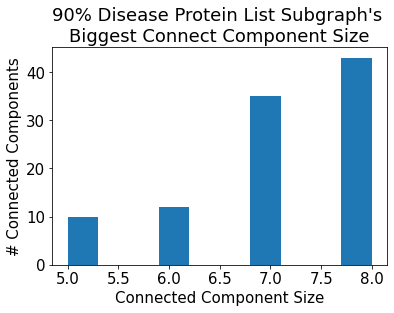

In [246]:
'''Create Disease Proteins Subgraph (90% of Narcolepsy-Associated Proteins)'''
disease_subgraphs_ccs_counts, disease_subgrahps_ccs = get_100_subgraphs(disease_proteins, ninety_percent_of_this_list = disease_proteins)
largest_cc_sizes = plot_largest_connected_component_histogram(title='90% Disease Protein List Subgraph\'s \nBiggest Connect Component Size',
                                                              subgraphs_ccs_counts = disease_subgraphs_ccs_counts)
print('Largest Size|Count')
display(pd.Series(sorted(largest_cc_sizes)).value_counts())
print(max(largest_cc_sizes), 'is the largest connected component')

Note: Subset size is the same number of random proteins as 90% of disease proteins
Largest Size|Count


11    7
6     6
7     6
8     6
12    6
10    5
22    5
16    5
20    4
15    4
32    4
17    4
9     4
21    3
24    3
29    3
37    3
14    2
18    2
19    2
5     2
13    2
23    2
26    2
36    1
49    1
46    1
4     1
35    1
34    1
33    1
54    1
dtype: int64

54 is the largest connected component
Average largest connected component 17.47


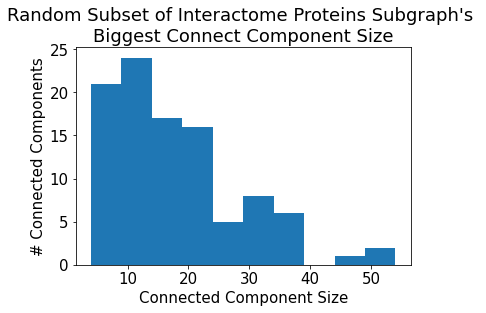

In [247]:
interactome_subgraphs_ccs_counts, interactome_subgrahps_ccs = get_100_subgraphs(interactome_proteins, ninety_percent_of_this_list = disease_proteins)
largest_cc_sizes = plot_largest_connected_component_histogram(title='Random Subset of Interactome Proteins Subgraph\'s \nBiggest Connect Component Size',
                                         subgraphs_ccs_counts = interactome_subgraphs_ccs_counts)
print('Note: Subset size is the same number of random proteins as 90% of disease proteins')
print('Largest Size|Count')
display(pd.Series(sorted(largest_cc_sizes)).value_counts())
print(max(largest_cc_sizes), 'is the largest connected component')
print('Average largest connected component', np.mean(largest_cc_sizes))

In [248]:
print('Proteins in the largest connected component of the disease protein subgraph:\n', 
      connected_components_sg100[0])

Proteins in the largest connected component of the disease protein subgraph:
 {'Q99571', 'O75821', 'O15547', 'Q99572', 'Q9UBL9', 'Q93086', 'Q96G91', 'Q9NQ55'}


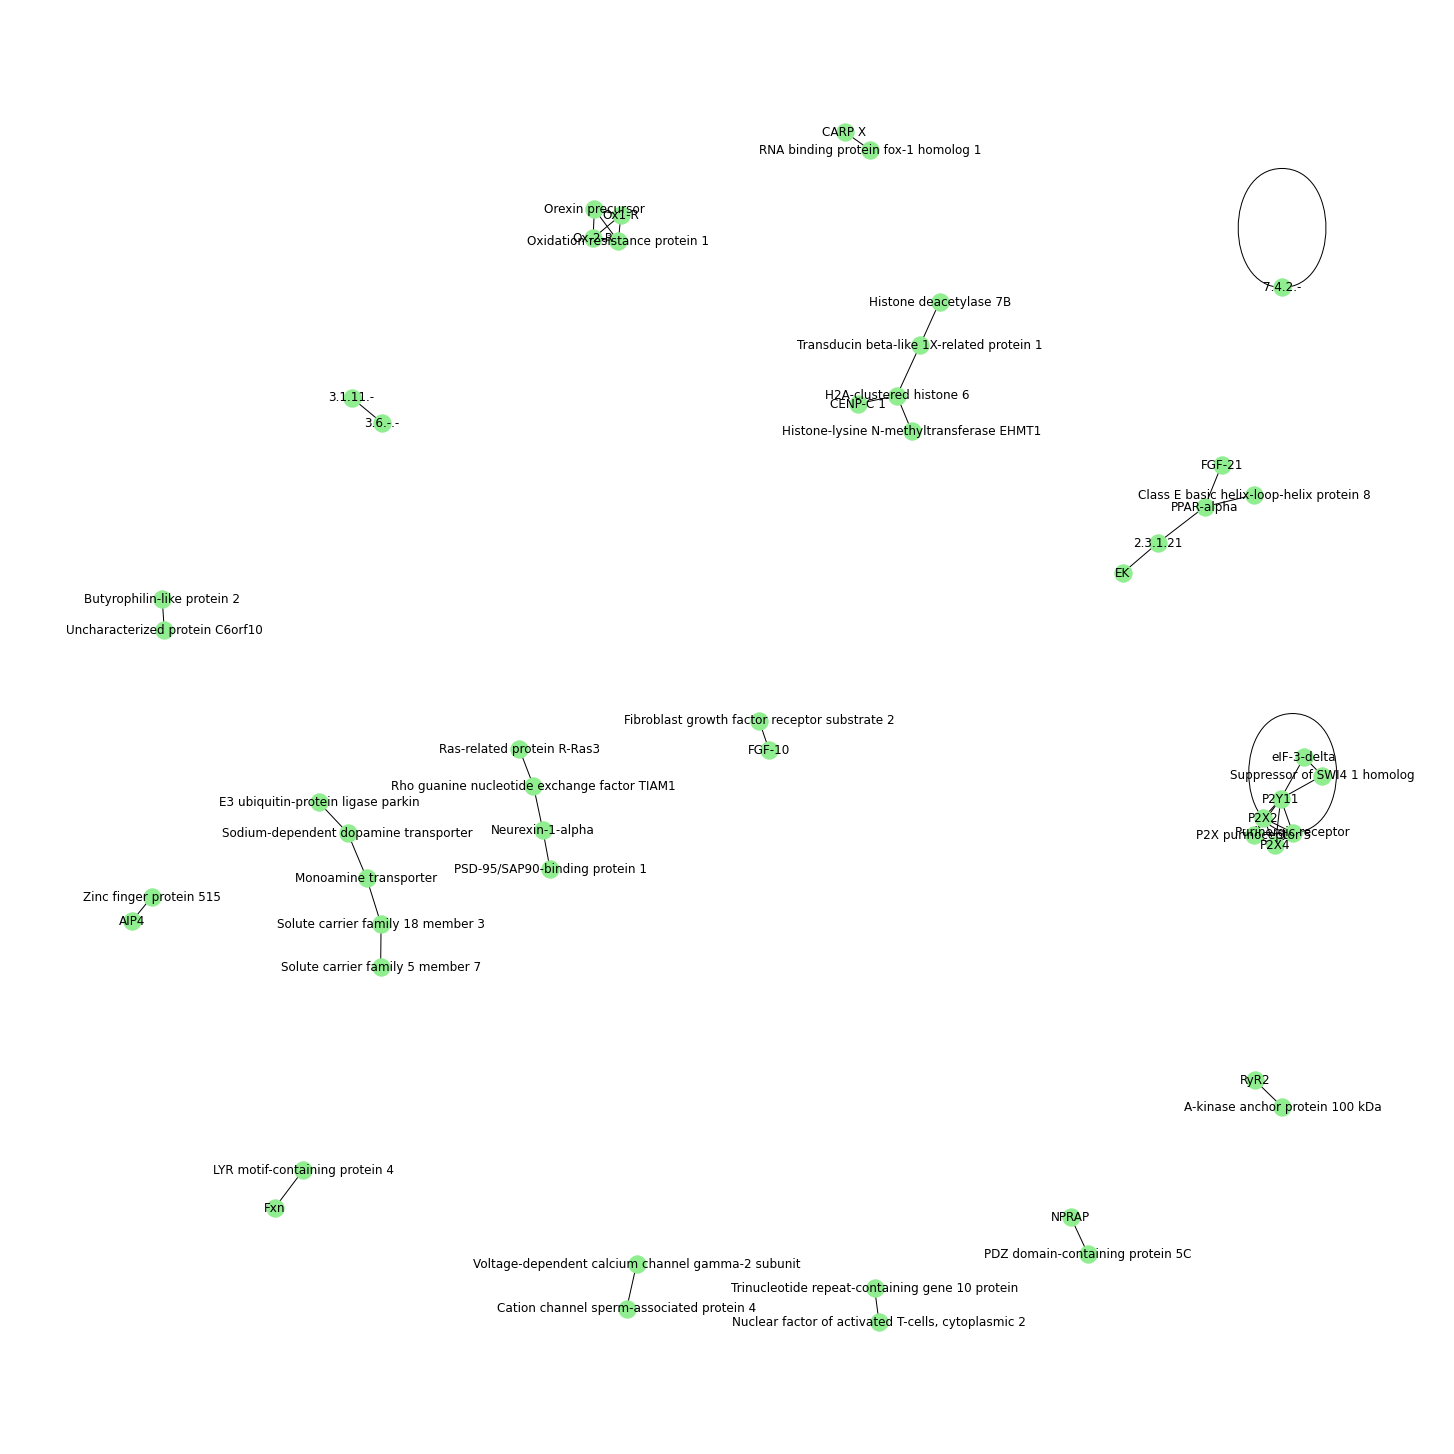

In [249]:
SG = G.subgraph(narcolepsy_proteins).to_undirected()
node2degree = {node:deg for (node, deg) in SG.degree()}
zero_deg_nodes = [node for node,degrees in node2degree.items() if degrees < 1]
SG_pruned = SG.copy()
SG_pruned.remove_nodes_from([node for node in SG_pruned if node in zero_deg_nodes])
SG_pruned = translate_proteinid2name_graph(SG_pruned, protein_id2names)

plt.figure(figsize=(20, 20))
nx.draw(SG_pruned, with_labels=True, node_color='lightgreen')